# Imports

In [249]:
import warnings
warnings.filterwarnings("ignore")

import os
import re
import torch
import mne
mne.set_log_level(verbose=None)

from tqdm import tqdm
import numpy as np
from matplotlib import pyplot as plt

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import classification_report
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Permute, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import SeparableConv2D, DepthwiseConv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import SpatialDropout2D
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import backend as K
from tensorflow.keras.losses import BinaryCrossentropy, SparseCategoricalCrossentropy,CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import BinaryAccuracy, AUC, Precision, Recall, CategoricalAccuracy
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

# Mode

In [250]:
MODE = "CLASSIC"
# MODE = "DOUBLE" # we double the size of the training subset by mixing the same amount of generated signals as the number in the original subset (6)
# MODE = "PRETRAIN" # pre-train EEGNet on the generated data and then re-train this initialized model with the real signals (7)

DATA = "BCICIV"
# DATA = "VEPESS"

# Global variables

In [251]:
BCICIV_PATH = "/kaggle/input/eegpreprocessed/pt_bciciv"
VEPESS_PATH = "/kaggle/input/eegpreprocessed/pt_vepess"
BCICIV_AUG_PATH = "/kaggle/input/eegpreprocessed/pt_bciciv_aug"
VEPESS_AUG_PATH = "/kaggle/input/eegpreprocessed/pt_vepess_aug"

N_TENSORS = -1
N_SEED = 1 # 5 for final report
 
if DATA == "BCICIV":
    PATH = BCICIV_PATH
    if MODE == "DOUBLE" or MODE == "PRETRAIN": 
        PATH_AUG = BCICIV_AUG_PATH
    N_CLASSES = 4
    classnames = ["0", "1", "2", "3"]
    N_CHANNELS = 25
    N_SAMPLES = 448
elif DATA == "VEPESS":
    PATH = VEPESS_PATH
    if MODE == "DOUBLE" or MODE == "PRETRAIN": 
        PATH_AUG = VEPESS_AUG_PATH
    N_CLASSES = 2
    classnames = ["34", "35"]
    N_CHANNELS = 70
    N_SAMPLES = 512

BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = BATCH_SIZE * 2 

FIRST_SPLIT = 0.15
SECOND_SPLIT = 0.1765

EPOCHS = 300
LEARNING_RATE = 1e-3
MIN_DELTA = 1e-5
PATIENCE = 20

# Preprocessing data functions

In [252]:
# Already sampled / preprocessed
def load_pt_data(path):
    cpt = 0
    data, labels, users = [], [], []
    for filename in tqdm(os.listdir(path)):
        if cpt >= N_TENSORS and N_TENSORS != -1:
            break
        f = os.path.join(path, filename)
        x, y, u = torch.load(f)
        data.append(x)
        labels.append(y)
        users.append(u)
        cpt += 1
    return np.array(data), np.array(labels), np.array(users)

def split_data(preprocessed_data, final_labels, final_user_idx):
    split = StratifiedShuffleSplit(n_splits=2, test_size=FIRST_SPLIT, random_state=0)
    for x_index, test_index in split.split(preprocessed_data, final_user_idx):
        X, X_test = preprocessed_data[x_index], preprocessed_data[test_index]
        y, y_test = final_labels[x_index], final_labels[test_index]
        users, users_test = final_user_idx[x_index], final_user_idx[test_index]
#     print(X.shape, X_test.shape, y.shape, y_test.shape)
#     print(np.unique(users, return_counts=True), np.unique(users_test, return_counts=True))
    split = StratifiedShuffleSplit(n_splits=2, test_size=SECOND_SPLIT, random_state=0)
    for train_index, valid_index in split.split(X, users):
        X_train, X_valid = X[train_index], X[valid_index] 
        y_train, y_valid = y[train_index], y[valid_index]
        users_train, users_valid = users[train_index], users[valid_index]
#     print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)
#     print(np.unique(y_train, return_counts=True), np.unique(y_test, return_counts=True))
#     print(np.unique(users_train, return_counts=True))
#     print(np.unique(users_valid, return_counts=True))
#     print(np.unique(users_test, return_counts=True))
    return X_train, y_train, X_valid, y_valid, X_test, y_test

def one_hot_data(y_train, y_valid, y_test):
    if DATA == "VEPESS":
        y_train = np.where(y_train==34, 0, 1)
        y_valid = np.where(y_valid==34, 0, 1)
        y_test = np.where(y_test==34, 0, 1)
    elif DATA == "BCICIV":
        y_train = y_train - 1
        y_valid = y_valid - 1
        y_test = y_test - 1
    y_train = tf.one_hot(y_train, depth=N_CLASSES, axis=0)
    y_valid = tf.one_hot(y_valid, depth=N_CLASSES, axis=0)
    y_test = tf.one_hot(y_test, depth=N_CLASSES, axis=0)
    return tf.transpose(y_train), tf.transpose(y_valid), tf.transpose(y_test)

def make_tensorflow_dataset(X_train, y_train, X_valid, y_valid, X_test, y_test):
    train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    valid_dataset = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))
    test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
    train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
    valid_dataset = valid_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
    test_dataset = test_dataset.batch(BATCH_SIZE)
    return train_dataset, valid_dataset, test_dataset

In [253]:
# FIRST_SPLIT = 0.15
# SECOND_SPLIT = 0.1765

# data = load_pt_data(PATH)
# X_train, y_train, X_valid, y_valid, X_test, y_test = split_data(data[0], data[1], data[2])
# print(X_train.shape, X_valid.shape, X_test.shape)

# Preprocessing data

In [254]:
if MODE == "CLASSIC":
    data = load_pt_data(PATH)
    X_train, y_train, X_valid, y_valid, X_test, y_test = split_data(data[0], data[1], data[2])
    y_train, y_valid, y_test = one_hot_data(y_train, y_valid, y_test)
    train_dataset, valid_dataset, test_dataset = make_tensorflow_dataset(X_train, 
                                                                         y_train, 
                                                                         X_valid, 
                                                                         y_valid, 
                                                                         X_test, 
                                                                         y_test)
elif MODE == "DOUBLE":
    data_base = load_pt_data(PATH)
    data_aug = load_pt_data(PATH_AUG)
    data = (np.concatenate((data_base[0], data_aug[0]), axis=0), 
            np.concatenate((data_base[1], data_aug[1]), axis=0), 
            np.concatenate((data_base[2], data_aug[2]), axis=0))
    X_train, y_train, X_valid, y_valid, X_test, y_test = split_data(data[0], data[1], data[2])
    y_train, y_valid, y_test = one_hot_data(y_train, y_valid, y_test)
    train_dataset, valid_dataset, test_dataset = make_tensorflow_dataset(X_train, 
                                                                         y_train, 
                                                                         X_valid, 
                                                                         y_valid, 
                                                                         X_test, 
                                                                         y_test)
elif MODE == "PRETRAIN":
    data_base = load_pt_data(PATH)
    data_aug = load_pt_data(PATH_AUG)
    X_train, y_train, X_valid, y_valid, X_test, y_test = split_data(data_base[0], data_base[1], data_base[2])
    y_train, y_valid, y_test = one_hot_data(y_train, y_valid, y_test)
    train_dataset, valid_dataset, test_dataset = make_tensorflow_dataset(X_train, 
                                                                         y_train, 
                                                                         X_valid, 
                                                                         y_valid, 
                                                                         X_test, 
                                                                         y_test)
    X_train_aug, y_train, X_valid, y_valid, X_test, y_test = split_data(data_aug[0], data_aug[1], data_aug[2])
    y_train_aug, y_valid_aug, y_test_aug = one_hot_data(y_train_aug, y_valid_aug, y_test_aug)
    train_dataset_aug, valid_dataset_aug, test_dataset_aug = make_tensorflow_dataset(X_train_aug, 
                                                                                     y_train_aug, 
                                                                                     X_valid_aug, 
                                                                                     y_valid_aug, 
                                                                                     X_test_aug, 
                                                                                     y_test_aug)

100%|██████████| 2592/2592 [00:03<00:00, 787.65it/s]


In [255]:
print(np.unique(y_train.numpy().argmax(axis=1), return_counts=True))
print(np.unique(y_valid.numpy().argmax(axis=1), return_counts=True))
print(np.unique(y_test.numpy().argmax(axis=1), return_counts=True))
print(X_train.min(), X_train.max(), X_train.mean(), X_train.std())

(array([0, 1, 2, 3]), array([467, 447, 446, 454]))
(array([0, 1, 2, 3]), array([ 80, 108,  98, 103]))
(array([0, 1, 2, 3]), array([101,  93, 104,  91]))
-1.0 1.0 0.02090923977469046 0.3440091484723757


# Model functions

In [256]:
def get_callbacks():
    return [
        # ModelCheckpoint(
        #     "best_eegnet.h5", save_best_only=True, monitor="val_loss"
        # ),
        # ReduceLROnPlateau(
        #     monitor="val_top_k_categorical_accuracy",
        #     factor=0.2,
        #     patience=2,
        #     min_lr=0.000001,
        # ),
        EarlyStopping(
            monitor="val_loss",
            min_delta=MIN_DELTA,
            patience=PATIENCE,
            verbose=1,
            mode="auto",
            baseline=None,
            restore_best_weights=True,
        ),
    ]

# https://arxiv.org/pdf/1611.08024.pdf
def EEGNet(n_classes, n_channels=64, n_samples=128, kernel_length=64, n_filters1=8, 
           n_filters2=16, depth_multiplier=2, norm_rate=0.25, dropout_rate=0.5, 
           dropoutType="Dropout"):

    if dropoutType == "SpatialDropout2D":
        dropoutType=SpatialDropout2D
    elif dropoutType == "Dropout":
        dropoutType=Dropout

    inputs = Input(shape=(n_channels, n_samples, 1))

    block1 = Conv2D(n_filters1, (1, kernel_length), padding="same", input_shape=(n_channels, n_samples, 1), use_bias=False)(inputs)
    block1 = BatchNormalization()(block1)
    block1 = DepthwiseConv2D((n_channels, 1), use_bias=False, depth_multiplier=depth_multiplier, depthwise_constraint=max_norm(1.0))(block1)
    block1 = BatchNormalization()(block1)
    block1 = Activation("elu")(block1)
    block1 = AveragePooling2D((1, 4))(block1)
    block1 = dropoutType(dropout_rate)(block1)

    block2 = SeparableConv2D(n_filters2, (1, 16), use_bias=False, padding="same")(block1)
    block2 = BatchNormalization()(block2)
    block2 = Activation("elu")(block2)
    block2 = AveragePooling2D((1, 8))(block2)
    block2 = dropoutType(dropout_rate)(block2)
    block2 = Flatten(name="flatten")(block2)

    classifier = Dense(n_classes, name="dense", kernel_constraint=max_norm(norm_rate))(block2)
    classifier = Activation("softmax", name="softmax")(classifier)

    model = Model(inputs=inputs, outputs=classifier) 

    optimizer = Adam(amsgrad=True, learning_rate=LEARNING_RATE)
    
    if DATA == "BCICIV":
        loss = CategoricalCrossentropy()
        acc = CategoricalAccuracy()
    elif DATA == "VEPESS":
        loss = BinaryCrossentropy()
        acc = BinaryAccuracy()
        
    model.compile(
            optimizer=optimizer,
            loss=loss,
            metrics=[
                acc,
    #             AUC(),
    #             Precision(),
    #             Recall(),
            ],
        )

    model.summary()

    return model

# def plot_history_metrics(history):
#     total_plots = len(history.history)
#     cols = total_plots // 2

#     rows = total_plots // cols

#     if total_plots % cols != 0:
#         rows += 1

#     pos = range(1, total_plots + 1)
#     plt.figure(figsize=(15, 10))
#     for i, (key, value) in enumerate(history.history.items()):
#         plt.subplot(rows, cols, pos[i])
#         plt.plot(range(len(value)), value)
#         plt.title(str(key))
#     plt.show()
    
def plot_history_metrics(histories):
    total_plots = len(histories[0].history)
    cols = total_plots // 2

    rows = total_plots // cols

    if total_plots % cols != 0:
        rows += 1

    pos = range(1, total_plots + 1)
    plt.figure(figsize=(15, 10))
    for history in histories:
        for i, (key, value) in enumerate(history.history.items()):
            plt.subplot(rows, cols, pos[i])
            plt.plot(range(len(value)), value)
            plt.title(str(key))
    plt.show()

# Training

In [257]:
classes = np.unique(y_train.numpy().argmax(axis=1))
class_weights = class_weight.compute_class_weight(class_weight="balanced", classes=classes, y=y_train.numpy().argmax(axis=1))
class_weights = dict(zip(classes, class_weights))
print(class_weights)

{0: 0.9710920770877944, 1: 1.0145413870246085, 2: 1.0168161434977578, 3: 0.998898678414097}


In [258]:
def run_train(model):
    if MODE == "CLASSIC" or MODE == "DOUBLE":
        history = model.fit(
            train_dataset,
            epochs=EPOCHS,
            callbacks=get_callbacks(),
            validation_data=valid_dataset,
            class_weight=class_weights,
        )
        return history, _
    elif MODE == "PRETRAIN":
        pretrain_history = model.fit(
            train_dataset_aug,
            epochs=EPOCHS,
            callbacks=get_callbacks(),
            validation_data=valid_dataset_aug,
            class_weight=class_weights_aug,
        )
        final_history = model.fit(
            train_dataset,
            epochs=EPOCHS,
            callbacks=get_callbacks(),
            validation_data=valid_dataset,
            class_weight=class_weights_aug,
        )
        return pretrain_history, final_history

In [259]:
histories = []
pretrain_histories = []
final_histories = []

for _ in range(N_SEED):
    model = EEGNet(n_classes=N_CLASSES, n_channels=N_CHANNELS, n_samples=N_SAMPLES)
    if MODE == "CLASSIC" or MODE == "DOUBLE":
        history, _ = run_train(model)
        histories.append(history)
    elif MODE == "PRETRAIN":
        pretrain_history, final_history = run_train(model)
        pretrain_histories.append(pretrain_history)
        final_histories.append(final_history)

Model: "model_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        [(None, 25, 448, 1)]      0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 25, 448, 8)        512       
_________________________________________________________________
batch_normalization_60 (Batc (None, 25, 448, 8)        32        
_________________________________________________________________
depthwise_conv2d_20 (Depthwi (None, 1, 448, 16)        400       
_________________________________________________________________
batch_normalization_61 (Batc (None, 1, 448, 16)        64        
_________________________________________________________________
activation_40 (Activation)   (None, 1, 448, 16)        0         
_________________________________________________________________
average_pooling2d_40 (Averag (None, 1, 112, 16)        0  

# Plotting learning curves

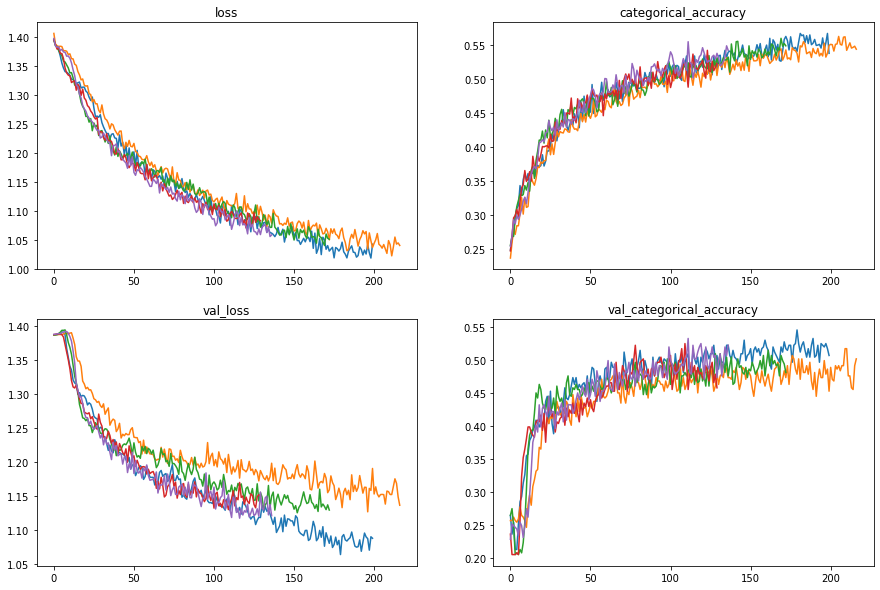

In [260]:
if MODE == "CLASSIC" or MODE == "DOUBLE":
    plot_history_metrics(histories)
elif MODE == "PRETRAIN":
    plot_history_metrics(pretrain_histories)
    plot_history_metrics(final_histories)

# Final evaluation on test set

In [261]:
# Trick to use plot function from sklearn
class estimator:
    _estimator_type = ""
    classes_ = []
    def __init__(self, model, classes):
        self.model = model
        self._estimator_type = "classifier"
        self.classes_ = classes
    def predict(self, X):
        return self.model.predict(X).argmax(axis=1)

classifier = estimator(model, classnames)

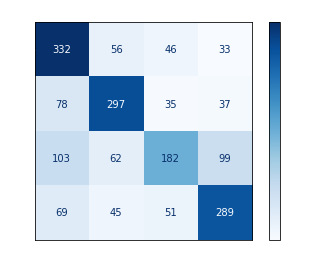

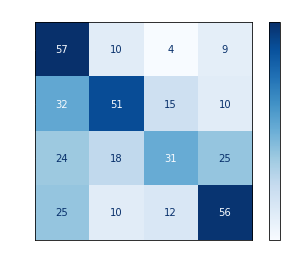

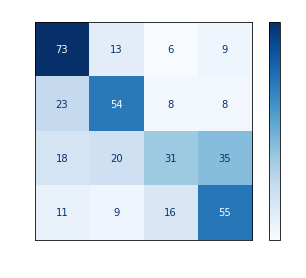

In [262]:
color = "white"

matrix = plot_confusion_matrix(classifier, X_train, y_train.numpy().argmax(axis=1), cmap=plt.cm.Blues)
matrix.ax_.set_title("Train confusion matrix", color=color)
plt.xlabel("Predicted Label", color=color)
plt.ylabel("True Label", color=color)
plt.gcf().axes[0].tick_params(colors=color)
plt.gcf().axes[1].tick_params(colors=color)
plt.show()

matrix = plot_confusion_matrix(classifier, X_valid, y_valid.numpy().argmax(axis=1), cmap=plt.cm.Blues)
matrix.ax_.set_title("Valid confusion matrix", color=color)
plt.xlabel("Predicted Label", color=color)
plt.ylabel("True Label", color=color)
plt.gcf().axes[0].tick_params(colors=color)
plt.gcf().axes[1].tick_params(colors=color)
plt.show()

matrix = plot_confusion_matrix(classifier, X_test, y_test.numpy().argmax(axis=1), cmap=plt.cm.Blues)
matrix.ax_.set_title("Test confusion matrix", color=color)
plt.xlabel("Predicted Label", color=color)
plt.ylabel("True Label", color=color)
plt.gcf().axes[0].tick_params(colors=color)
plt.gcf().axes[1].tick_params(colors=color)
plt.show()

In [263]:
y_pred = model.predict(X_test).argmax(axis=1)
y_true = y_test.numpy().argmax(axis=1)
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.58      0.72      0.65       101
           1       0.56      0.58      0.57        93
           2       0.51      0.30      0.38       104
           3       0.51      0.60      0.56        91

    accuracy                           0.55       389
   macro avg       0.54      0.55      0.54       389
weighted avg       0.54      0.55      0.53       389



In [264]:
# Expected results from the paper :
    # Results: although the mixed training gave slightly better accuracy on the validation subset during
    # training, it did not improve the accuracy of the test set. On the contrary, with the pre-training
    # approach, the model converged faster and achieved better accuracy on the test. These observations
    # imply that although EEGWave was able to learn the main characteristics of the real signals, it could
    # not produce signals that are diverse enough to regularize EEGNet.
    
# Our results :
    #
    #
    #
    #
    #